In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# sklearn
from sklearn.model_selection import GroupKFold,StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#gensim
from gensim import models, corpora
import gensim

unable to import 'smart_open.gcs', disabling that module


In [2]:
# load data and dictionary
df_plot = pd.read_csv('/Users/YukiZ./Desktop/565/clean_data_v3.csv',usecols=['Title','Cleaned_Plot'])
df_plot = df_plot[['Title','Cleaned_Plot']]
df_genre = pd.read_csv('/Users/YukiZ./Desktop/565/classification.csv',usecols=['Title','genre','genre_index'])
df = pd.merge(df_genre,df_plot,how='inner',on='Title')

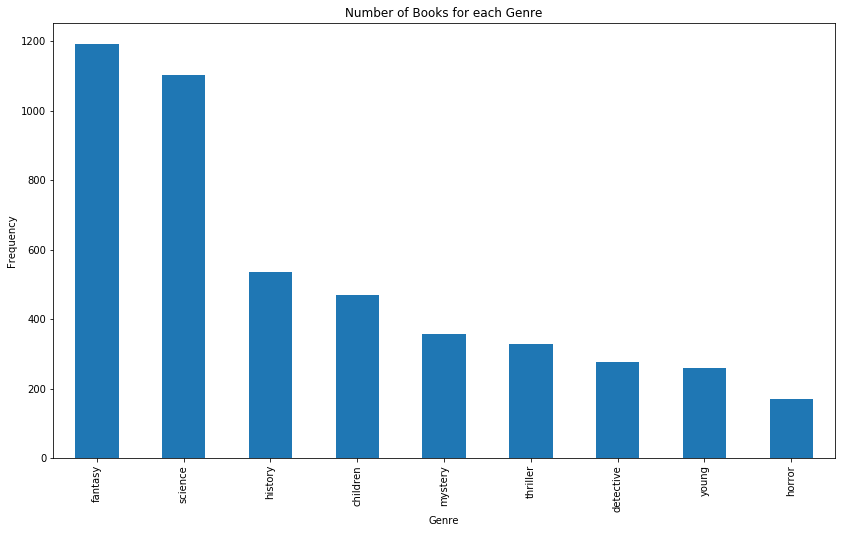

In [3]:
# vis for each category
ax = df['genre'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of Books for each Genre")
ax.set_xlabel("Genre")
ax.set_ylabel("Frequency")
plt.show()

In [4]:
# split training and testing set
def groupSplit(X,y,test_size=0.2,n_splits=1):
    
    split = StratifiedShuffleSplit(n_splits = n_splits, test_size = test_size,random_state = 0)
    for train_idx,test_idx in split.split(X,y):
        X_train,X_test = X[train_idx],X[test_idx]
        y_train,y_test = y[train_idx],y[test_idx]
    X_train.reset_index(inplace=True, drop=True)
    y_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    return X_train,y_train,X_test,y_test


X = df['Cleaned_Plot'].apply(lambda x:x.split())
y = df['genre']
X_train,y_train,X_test,y_test = groupSplit(X,y)
X_train,y_train,X_val,y_val = groupSplit(X_train,y_train)

In [5]:
# Data Preprocessing
def dataPreprocessing(X):
    '''
    Args:
        X: documents, each sample with a list of tokens

    Return:
        dictionary: index(key): words(values)
        corpus_tfidf: a list of documents which are represented by TF-IDF
    '''
    # create a dictionary, map index to words
    dictionary = corpora.Dictionary(X)
    
    # apply bag of words for input, here the index would represent for words
    corpus = [dictionary.doc2bow(text)for text in X]
    
    return dictionary, corpus

# Apply TF-IDF model
dictionary,X_bow = dataPreprocessing(X_train)
X_val_bow = [dictionary.doc2bow(doc) for doc in X_val]
X_test_bow = [dictionary.doc2bow(doc) for doc in X_test]

In [6]:
# bow_corpus = [dictionary.doc2bow(doc) for doc in X_train]
# dictionary = gensim.corpora.Dictionary(X_train)

In [7]:
def topicsRepresent(X,lda_model,dictionary,num_topics):
    X_lda = []
    for doc in X:
        topics = [0 for i in range (np.max(num_topics))]
        topics1 = lda_model[dictionary.doc2bow(doc)]
        for item in topics1:
            topics[item[0]] = item[1]
        X_lda.append(topics)
    return X_lda

In [8]:
i = 50
lda = gensim.models.ldamodel.LdaModel(X_bow, num_topics=i, id2word=dictionary)

In [11]:
# select number of topics for lsi 
def topicsSelection(num_topics,X_train=X_train, y_train=y_train, X_test=X_test,\
                    y_test=y_test,dictionary=dictionary,test_report = False,train_report = False):

    train_accuracy = []
    test_accuracy = []
    for i in num_topics:
        # train lda model
        lda = gensim.models.ldamodel.LdaModel(X_bow, num_topics=i, id2word=dictionary, passes = 4)
        
        # get ldatopics
        X_train_lda = topicsRepresent(X_train,lda,dictionary,num_topics) 
        X_test_lda = topicsRepresent(X_test,lda,dictionary,num_topics)
        
        model = LogisticRegression(solver = 'lbfgs')
        model.fit(X_train_lda, y_train)
        
        # accuracy
        y_pred = model.predict(X_train_lda)
        train_accuracy.append(metrics.accuracy_score(y_train, y_pred))
        if train_report:
            print("The report for training set is:")
            print(metrics.classification_report(y_train, y_pred))
        
        y_pred = model.predict(X_test_lda)
        test_accuracy.append(metrics.accuracy_score(y_test, y_pred))
        if test_report:
            print("The report for testing set is:")
            print(metrics.classification_report(y_test, y_pred))
        
    return train_accuracy,test_accuracy
    

In [12]:
num_topics = [i for i in range(5,101,5)]
train_accuracy,val_accuracy = topicsSelection(num_topics= num_topics, X_test = X_val, y_test=y_val)

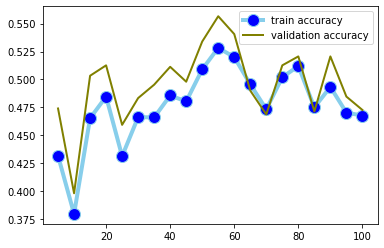

In [13]:
plt.plot(num_topics, train_accuracy, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label = 'train accuracy')
plt.plot(num_topics, val_accuracy,  marker='', color='olive', linewidth=2,label='validation accuracy')
plt.legend()

Here, we find the optimal number of topics is in the interval from 20 to 40. Then, we will perform a grid search in this interval.

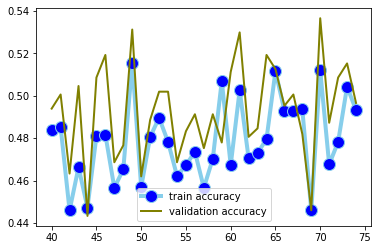

In [16]:
num_topics = [i for i in range(40,75)]
train_accuracy,val_accuracy = topicsSelection(num_topics= num_topics,X_test = X_val,
                                              y_test=y_val)
plt.plot(num_topics, train_accuracy, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label = 'train accuracy')
plt.plot(num_topics, val_accuracy,  marker='', color='olive', linewidth=2,label='validation accuracy')
plt.legend()

Here, we pick up 36 as our final number of topics for LSI model.

In [17]:
X_train_all = list(X_train)+list(X_val)
y_train_all = list(y_train)+list(y_val)
train_accuracy,test_accuracy = topicsSelection(num_topics= [36],X_train=X_train_all,y_train=y_train_all,X_test = X_test,
                                            y_test=y_test,test_report=True,train_report=True)

The report for training set is:
              precision    recall  f1-score   support

    children       0.39      0.52      0.45       376
   detective       0.41      0.32      0.36       222
     fantasy       0.49      0.65      0.56       953
     history       0.35      0.22      0.27       429
      horror       0.00      0.00      0.00       136
     mystery       0.35      0.36      0.36       285
     science       0.56      0.71      0.63       881
    thriller       0.44      0.22      0.29       262
       young       0.38      0.04      0.08       207

    accuracy                           0.47      3751
   macro avg       0.38      0.34      0.33      3751
weighted avg       0.44      0.47      0.44      3751

The report for testing set is:
              precision    recall  f1-score   support

    children       0.40      0.43      0.41        94
   detective       0.54      0.27      0.36        55
     fantasy       0.54      0.75      0.63       239
     history   

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
train_accuracy

[0.47400693148493733]

In [18]:
print('The testing accuracy is: ', round(test_accuracy[0],3))

The testing accuracy is:  0.52
